In [1]:
# import tools
import pandas as pd
%matplotlib inline
import qiime2
from qiime2 import Artifact
from tempfile import mkdtemp
from qiime2.plugins import demux, deblur, quality_filter, \
                           metadata, feature_table, alignment, \
                           phylogeny, diversity, emperor, feature_classifier, \
                           taxa, composition
from qiime2.plugins import fragment_insertion
from qiime2.plugins.fragment_insertion.methods import filter_features
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.visualizers import summarize
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pylab
from scipy.optimize import curve_fit

## Import data

In [99]:
# import raw feature table and taxonomy
table = Artifact.load('96057_feature-table.qza')
tx = Artifact.load('96057_reference-hit.taxonomy_gg.qza').view(pd.DataFrame)

## Repeat with ASV

In [122]:
# see what it looks like at ASV level
df_raw = table.view(pd.DataFrame)
df_raw_zymo = df_raw[df_raw.index.str.contains('Zymo')]
# ensure table values are numeric
df_raw_zymo = df_raw_zymo.astype(float)
# quick visual check that top 7 taxa make up most of the reads in highest input sample (well A7)
max_input = df_raw_zymo[df_raw_zymo.index.str.contains("A7")]
df_raw_zymoT = max_input.T
top10 = df_raw_zymoT.sort_values(df_raw_zymoT.columns[0], ascending = False).head(10)
# add in taxonomy
top10tx = pd.merge(top10, tx, left_index=True, right_index=True)
top10tx.reset_index(inplace=True)
top10tx.set_index('Taxon').head(10)
#top10tx['index'].to_csv('/Users/lisamarotz/Desktop/temp.csv')

,index,13092.v2.06.ZymoMock.A7,13092.v2.13.ZymoMock.A7,13092.v2.05.ZymoMock.A7,13092.v2.14.ZymoMock.A7,Confidence
Taxon,,,,,,
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCA...,25199.0,17120.0,23360.0,19977.0,0.9999995077760527
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCA...,23808.0,15474.0,22929.0,18617.0,0.9999999399832155
k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Enterococcaceae; g__Enterococcus,TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGAG...,12120.0,9014.0,12239.0,9477.0,0.8381339317137253
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__Pseudomonas,TACGAAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCG...,8524.0,3420.0,7841.0,8765.0,0.7568461062511695
k__Bacteria; p__Firmicutes; c__Bacilli,TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGCG...,7528.0,5924.0,7321.0,6265.0,0.999999999827695
k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__,TACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCT...,6197.0,4910.0,6306.0,4676.0,0.9547623319560599
k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus; s__,TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGAGAG...,4780.0,4355.0,5274.0,2935.0,0.8940640260282465
k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Listeriaceae; g__Listeria,TACGTAGGTGGCAAGCGTTGTCCGGATTTATTGGGCGTAAAGCGCG...,2732.0,2302.0,2887.0,2316.0,0.9317293667259242
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae,TACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCA...,778.0,618.0,582.0,636.0,0.9999998276935724


In [101]:
# make a list of the taxa expected in the zymo community (also the  most abundant in the highest input samples)
bacteria8 = top8.index

In [102]:
# Calculate the total number of reads per sample
df_raw_zymo['deblur_reads'] = df_raw_zymo.sum(axis=1)
# calculate the number of reads aligning to the mock community input genera
df_raw_zymo['zymo_reads'] = df_raw_zymo[bacteria8].sum(axis=1)
# calculate the percent correctly assigned
df_raw_zymo['correct_assign'] = df_raw_zymo['zymo_reads'] / df_raw_zymo['deblur_reads']

In [104]:
# subset out KatharoSeq columns and add in logarithim of reads for plotting
katharo = df_raw_zymo[['correct_assign','deblur_reads','zymo_reads']]
katharo['log_deblur_reads'] = np.log10(katharo['deblur_reads'])

/Users/lisamarotz/miniconda2/envs/qiime2-2020.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Fit an allosteric sigmoid curve for extrpolating min read count #

[   8.85899855 3103.65322312]


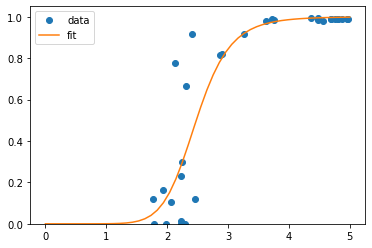

In [105]:
# define the allosteric sigmoid equation
def allosteric_sigmoid(x, h, k_prime):
    y = x ** h / (k_prime + x ** h)
    return y
 
# fit the curve to your data
popt, pcov = curve_fit(allosteric_sigmoid, katharo['log_deblur_reads'], katharo['correct_assign'], method='dogbox')
print(popt)
# plot fit curve
x = np.linspace(0, 5, 50)
y = allosteric_sigmoid(x, *popt)

# plot the fit
pylab.plot(katharo['log_deblur_reads'], katharo['correct_assign'], 'o', label='data')
pylab.plot(x,y, label='fit')
pylab.ylim(0, 1.05)
pylab.legend(loc='best')
pylab.show()

In [106]:
# Determine the number of reads at which 50% of reads are expected to match input

# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.5 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_50 = np.power(10, min_log_reads).astype(int)
min_freq_50

300

In [107]:
# Determine the number of reads at which 80% of reads are expected to match input

# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.8 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_80 = np.power(10, min_log_reads).astype(int)
min_freq_80

790

In [123]:
# Determine the number of reads at which 90% of reads are expected to match input

# assign variables and solve for X (number of reads to pass filter)
h = popt[0]  # first value printed above graph
k = popt[1]   # second value printed above graph
y = 0.9 ## what you want to solve for

min_log_reads = np.power((k/(1/y-1)),(1/h))
min_freq_90 = np.power(10, min_log_reads).astype(int)
min_freq_90

1499

## Remove samples with less than Katharoseq read limit

In [109]:
# filter out samples with read counts below what is estimated to achieve 50% accuracy  
KS_table_50 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_50)
df_50 = KS_table_50.filtered_table.view(pd.DataFrame)

In [110]:
# filter out samples with read counts below what is estimated to achieve 80% accuracy  
KS_table_80 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_80)
df_80 = KS_table_80.filtered_table.view(pd.DataFrame)

In [111]:
# filter out samples with read counts below what is estimated to achieve 90% accuracy  
KS_table_90 = feature_table.methods.filter_samples(table = table,
                             min_frequency = min_freq_90)
df_90 = KS_table_90.filtered_table.view(pd.DataFrame)

In [124]:
# import collapsed table as pandas dataframe
print("full dataset", len(df), "\n",
      "50%", len(df_50), len(df_50)/len(df),"%", "\n",
      "80%", len(df_80), len(df_80)/len(df),"%", "\n",
      "90%", len(df_90), len(df_90)/len(df),"%",)

full dataset 333 
 50% 213 0.6396396396396397 % 
 80% 169 0.5075075075075075 % 
 90% 146 0.43843843843843844 %


### Export Data

In [125]:
KS_table_80.filtered_table.save('96057_feature-table-KathSeqFilASV.qza')

'96057_feature-table-KathSeqFilASV.qza'